In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.set_figure_params(dpi=100)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
adata = sc.read("merged_processed_cleaned.h5ad")

In [4]:
adata.X.max()

3.4719665

In [5]:
adata.X = adata.layers["counts"].copy()

In [6]:
adata.X.max()

137.0

In [7]:
target_sum=1e3

In [8]:
# label_transfer

In [9]:
adata_kidney = sc.read("/data/projects/robin/singlecell/kidney/Lake/cellxgene_obj.h5ad")
adata_kidney.var = adata_kidney.var.set_index("feature_name")

/opt/conda/envs/xenium_cgn/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [10]:
common = list(set(adata_kidney.var_names.tolist())&set(adata.var_names.tolist()))
adata_kidney = adata_kidney[:, common]
adata_test = adata[:, common]

In [11]:
adata_kidney.X.max()

7.816792

In [12]:
adata_kidney.layers["logcounts_original"] = adata_kidney.X.copy()

/tmp/ipykernel_63753/813252101.py:1: ImplicitModificationWarning: Setting element `.layers['logcounts_original']` of view, initializing view as actual.
  adata_kidney.layers["logcounts_original"] = adata_kidney.X.copy()


In [13]:
adata_kidney.X = 10**np.array(adata_kidney.X.todense())-1
adata_kidney.X.min(), adata_kidney.X.max()

(0.0, 65583110.0)

In [14]:
sc.pp.normalize_total(adata_test, target_sum=target_sum)
sc.pp.log1p(adata_test)

sc.pp.normalize_total(adata_kidney, target_sum=target_sum)
sc.pp.log1p(adata_kidney)

/opt/conda/envs/xenium_cgn/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
adata_kidney.obs[["subclass.l1"]].drop_duplicates().to_csv("subclass.l1.csv")
adata_kidney.obs[["subclass.l2"]].drop_duplicates().to_csv("subclass.l2.csv")

In [16]:
idxs = adata_kidney[adata_kidney.obs["subclass.l1"]=="IMM"].obs.index
len(idxs)
adata_kidney.obs["subclass.l1"] = adata_kidney.obs["subclass.l1"].astype(str)
adata_kidney.obs.loc[idxs, "subclass.l1"] = adata_kidney.obs.loc[idxs, "subclass.l2"].tolist()

In [17]:
idxs = adata_kidney[adata_kidney.obs["structure"].str.contains("renal corpuscle")].obs.index
adata_kidney.obs["subclass.l1"] = adata_kidney.obs["subclass.l1"].astype(str)
adata_kidney.obs.loc[idxs, "subclass.l1"] = adata_kidney.obs.loc[idxs, "subclass.l2"].tolist()

In [18]:
adata_kidney.obs["subclass.l1"].replace({"dPOD": "POD"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"POD": "podocyte"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"EC-GC": "glomerular endothelial cell"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"MC": "mesangial cell"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"PEC": "parietal epithelial cell"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"glomerular endothelial cell": "endothelial cell"}, inplace=True)
adata_kidney.obs["subclass.l1"].replace({"MAC-M2": "MAC"}, inplace=True)


In [19]:
common = list(set(adata.var.index.tolist())&set(adata_kidney.var.index.tolist()))
print(len(common))

472


In [20]:
adata_kidney.obs["subclass.l1"].value_counts()

subclass.l1
PT                          76031
TAL                         66257
PC                          23239
EC                          21411
IC                          18001
FIB                         16548
CNT                         13245
DCT                         13216
DTL                          9786
T                            7118
VSM/P                        6249
MDC                          4441
NKC/T                        4201
endothelial cell             3764
MAC                          3533
ATL                          3384
podocyte                     2832
ncMON                        2435
parietal epithelial cell     2417
B                            2194
PL                           1353
N                             860
PapE                          531
mesangial cell                458
MAST                          400
cDC                           216
cycMNP                        215
cycNKC/T                      165
NEU                            77
pD

In [21]:
adata_train = adata_kidney[:, common]

In [22]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [23]:
clf = LogisticRegressionCV(random_state=42)

In [24]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()

In [25]:
le.fit(adata_train.obs["subclass.l1"])

LabelEncoder()

In [26]:
adata_train.obs["subclass.l1_codes"] = le.transform(adata_train.obs["subclass.l1"])

/tmp/ipykernel_63753/1100352379.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["subclass.l1_codes"] = le.transform(adata_train.obs["subclass.l1"])


In [27]:
X = np.array(adata_train.X)
y = np.array(adata_train.obs["subclass.l1_codes"])

In [28]:
clf.fit(X, y)

/opt/conda/envs/xenium_cgn/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [29]:
X_test = np.array(adata_test.X.todense())

In [30]:
probs = clf.predict_proba(X_test)
print(probs.shape)
max_probs = probs.max(1)

(3232336, 30)


In [31]:
max_probs

array([0.99677553, 0.99952703, 0.99985764, ..., 0.99833381, 0.68304081,
       0.67870212])

In [32]:
adata_test.obs["subclass.l1_codes"] = clf.predict(X_test)
adata_test.obs["subclass.l1_prob"] = max_probs
adata_test.obs["subclass.l1"] = le.inverse_transform(adata_test.obs["subclass.l1_codes"])

In [33]:
adata_test.uns["subclass.l1_colors"] = list(sns.color_palette("colorblind", len(adata_test.obs["subclass.l1"].unique())).as_hex())

In [34]:
print((adata.obs.index==adata_test.obs.index).all())

True


In [35]:
adata_proc = sc.read("merged_processed.h5ad")
print((adata_proc.obs.index==adata_test.obs.index).all())

True


In [36]:
adata_proc.obs["celltype_l1"] = adata_test.obs["subclass.l1"].tolist()
adata_proc.obs["celltype_l1_codes"] = adata_test.obs["subclass.l1_codes"].tolist()
adata_proc.obs["celltype_l1_prob"] = adata_test.obs["subclass.l1_prob"].tolist()


In [37]:
adata_proc = adata_proc[adata_proc.obs.Disease!="Sample"]
adata_proc.shape

(3230744, 480)

In [38]:
tab = pd.crosstab(adata_proc.obs["celltype_l1"], adata_proc.obs["Disease"])

In [39]:
tab = tab.T
order = ["Cntrl", "SLE", "ANCA", "GBM"]
tab = tab.loc[order]

In [40]:
tab = tab.div(tab.sum(1),0)*100

In [41]:
tab = tab[sorted(tab.columns)]

Text(0.5, 1.0, '%')

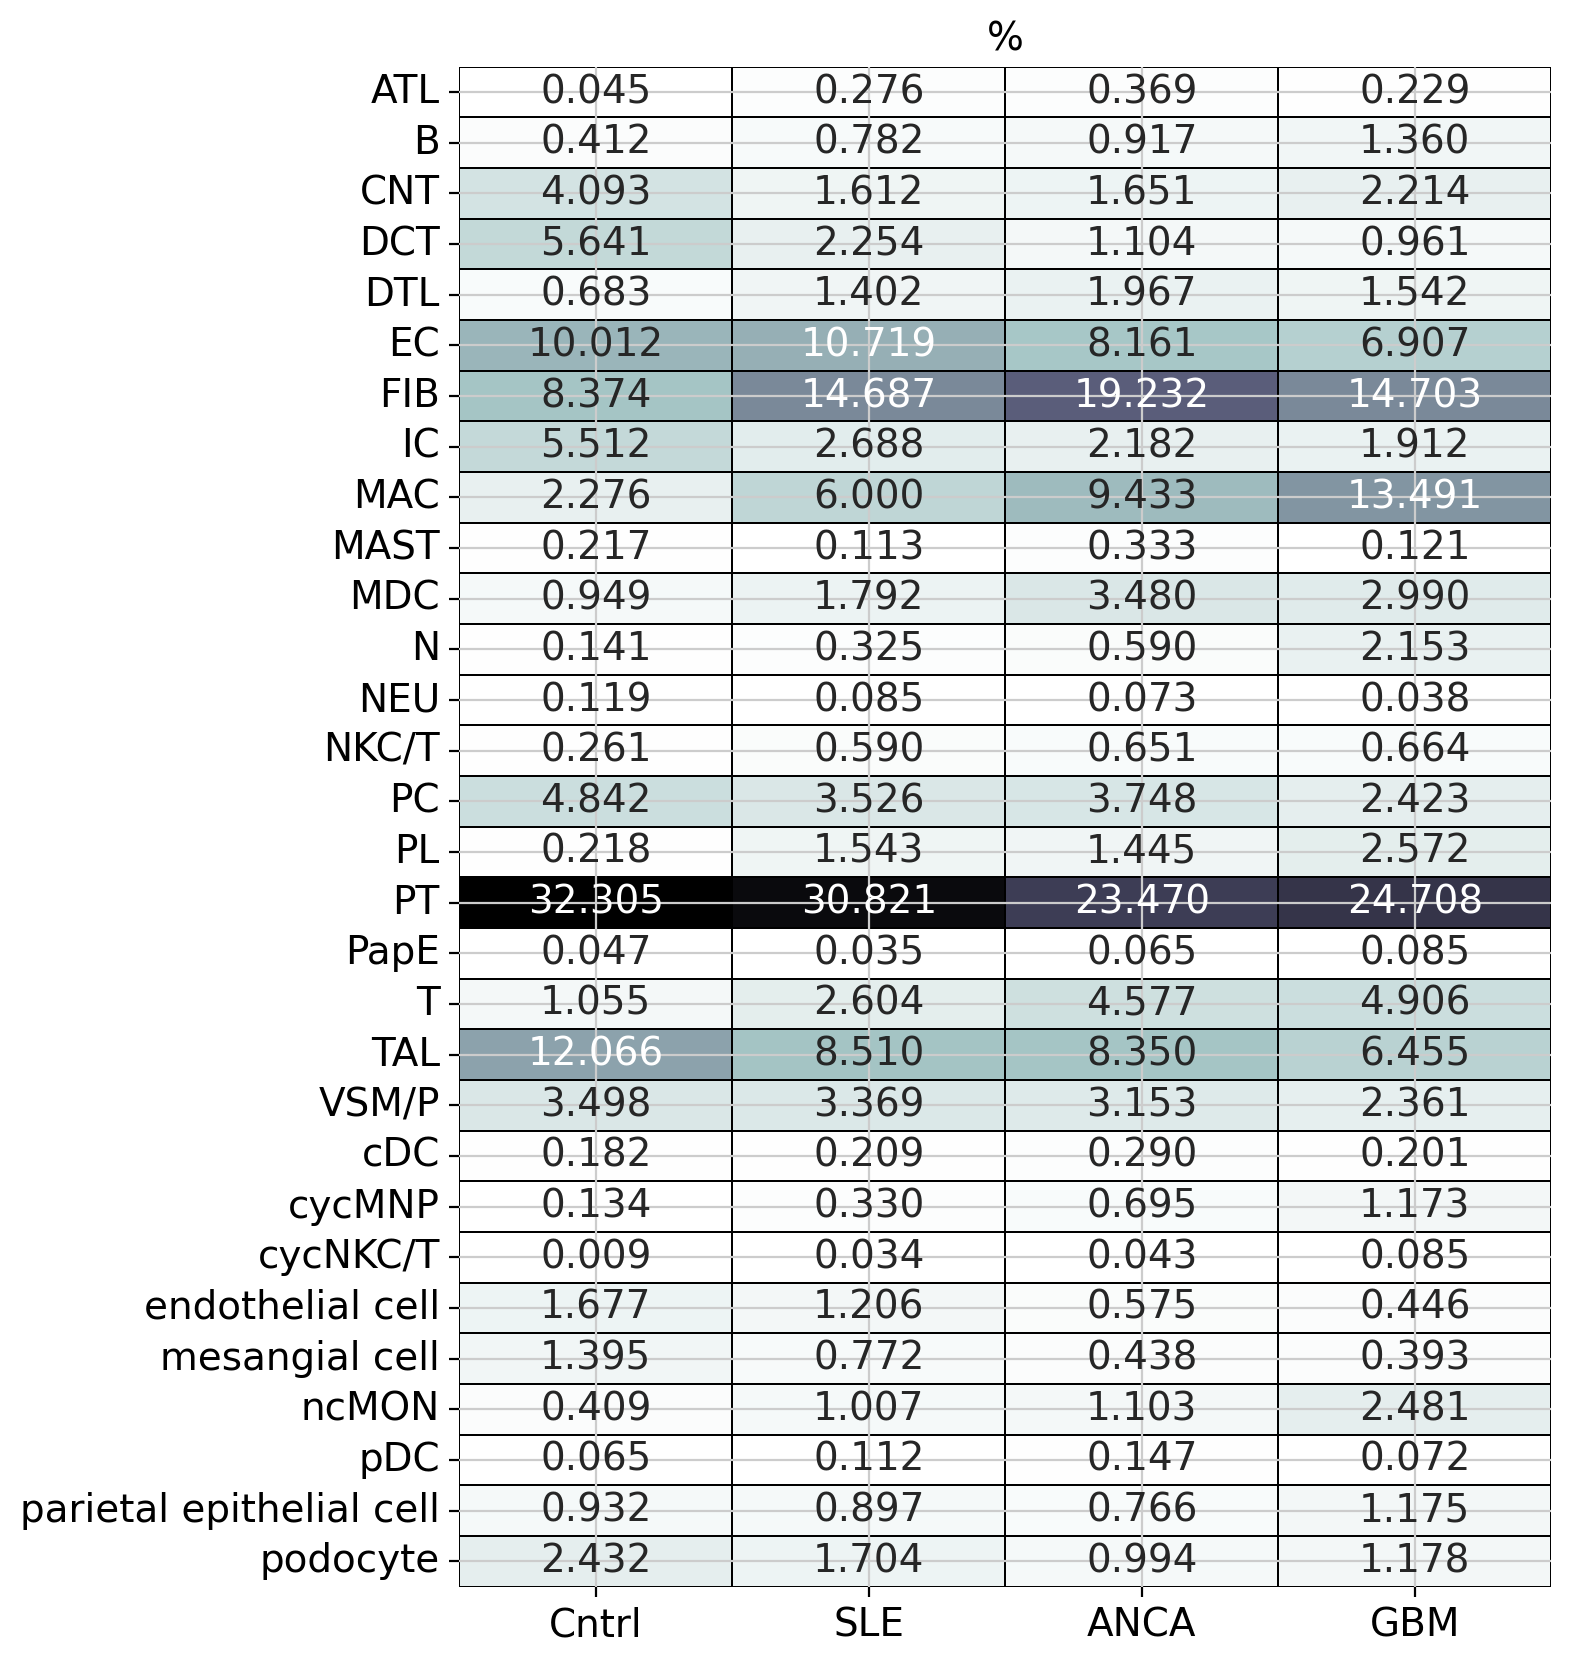

In [42]:
plt.figure(figsize=(7,10))
ax=sns.heatmap(tab.T, annot=True, fmt=".3f", cmap="bone_r", linewidths=0.05, linecolor="black", cbar=False)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("%")

In [43]:
adata_proc.obs.celltype_l1.replace({"endothelial cell": "EC",
                                   "parietal epithelial cell": "PEC"}, inplace=True)

In [44]:
markers = ["PODXL", "PDGFRB", "CLDN1", "PECAM1", "COL1A1", "LRP2", "VCAM1", "SLC12A3", "CALB1",
           "UMOD","TACSTD2",  "AQP2", "ATP6V0D2", 
           "NRXN1", 
           "PTPRC", "MS4A2", "S100A9", "CD163", "CD14", "FCGR3A", "ITGAX", "CLEC4C",  "CLEC9A", 
           "CD38", "JCHAIN", "MS4A1", "CD3D", "GZMA"]         

In [45]:
order = ["podocyte", "mesangial cell", "PEC", "EC", "FIB", 'VSM/P', "PT", "DCT", "CNT", "TAL", "ATL", "DTL", "PC", "IC", \
         "PapE", 'NEU',
        'MAST', 'N', 'MAC', 'ncMON',  'MDC','pDC', 
            'PL', 'B',  'T', 
         'cDC', 'cycMNP',  'NKC/T', 'cycNKC/T', ]
adata_proc.obs["celltype_l1"] = adata_proc.obs["celltype_l1"].astype("category").cat.reorder_categories(order)

/tmp/ipykernel_63753/219781197.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_proc.obs["celltype_l1"] = adata_proc.obs["celltype_l1"].astype("category").cat.reorder_categories(order)


In [46]:
adata_proc.write("xenium_outs/merged_processed.h5ad")

In [50]:
adata_proc.layers["scaled"] = sc.pp.scale(adata_proc, max_value=10, copy=True).X.copy()

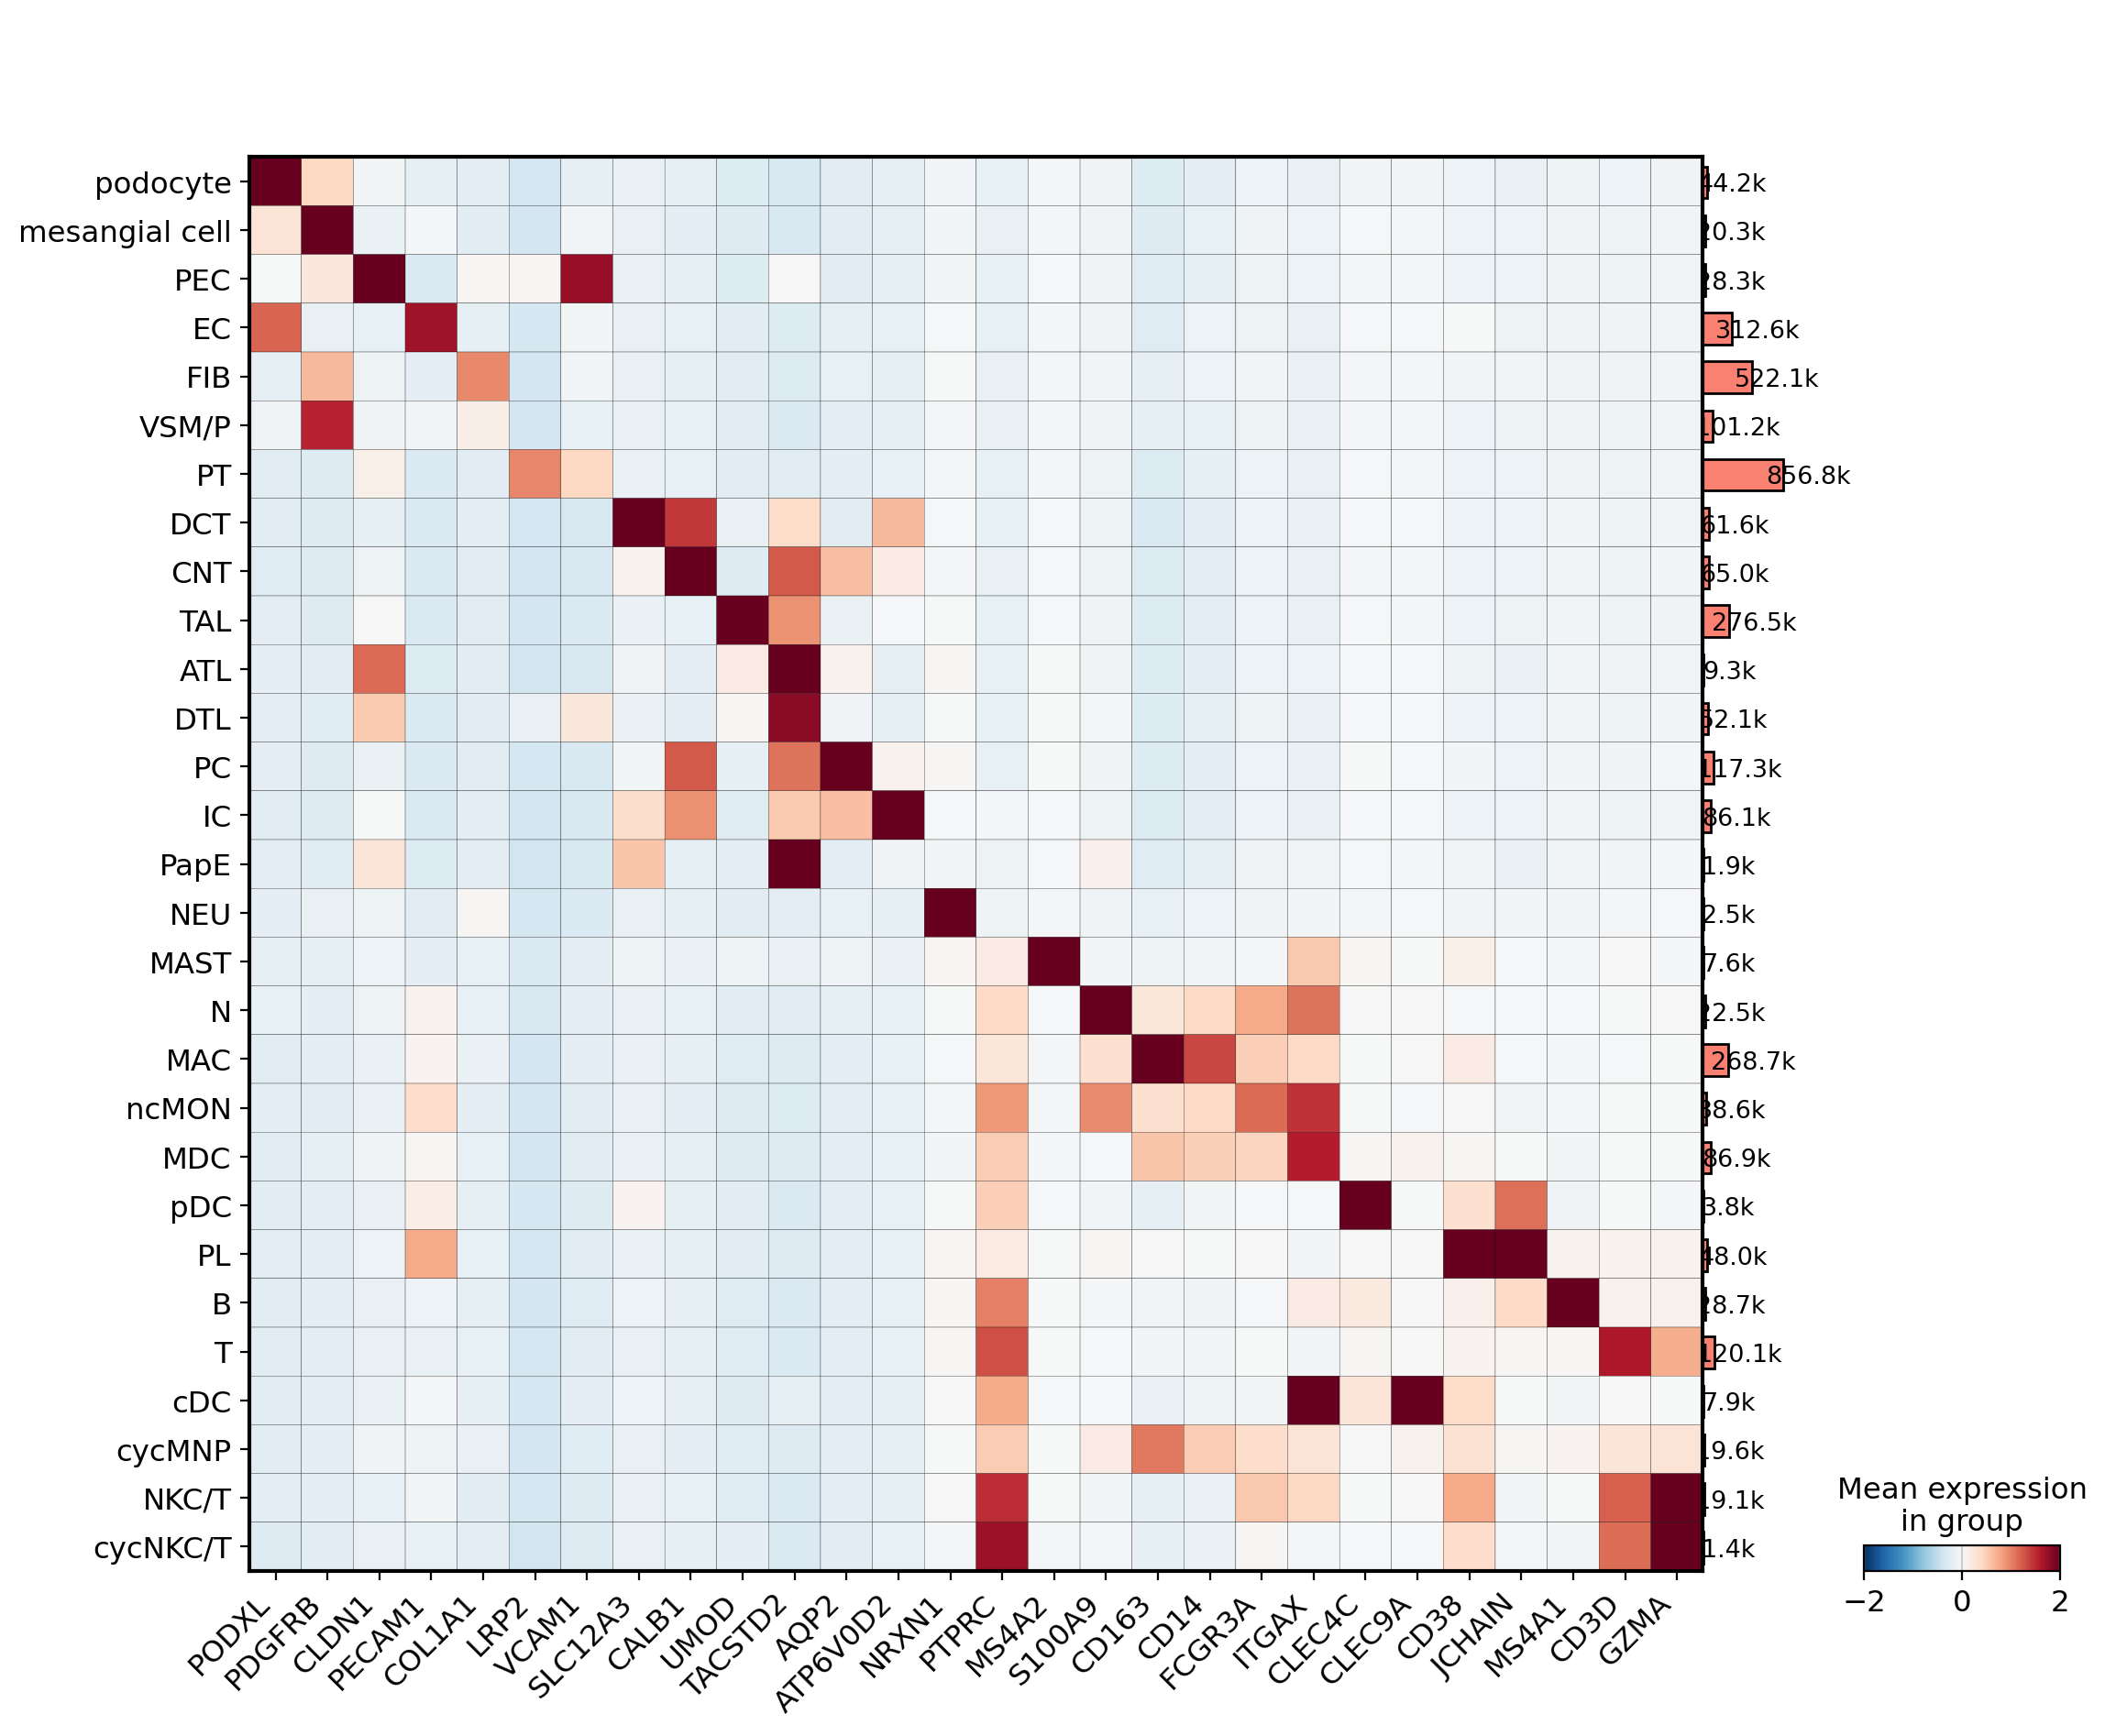

In [51]:
import matplotlib.pyplot as plt
mp=sc.pl.matrixplot(adata_proc, groupby="celltype_l1", var_names=markers, dendrogram=False, vmin=-2,
                 cmap="RdBu_r", vmax=2,
                layer="scaled", return_fig=True)
mp.add_totals().style(edge_color='black', cmap="RdBu_r").savefig("matrixplot_markers_RdBu.png", bbox_inches="tight")
mp.ax_dict["mainplot_ax"].set_xticklabels(mp.ax_dict["mainplot_ax"].get_xticklabels(), rotation=45, ha="right")

plt.savefig("matrixplot_markers_RdBu_natlog.png", facecolor='white', transparent=False)
plt.show()

-----